In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

<!-- dom:TITLE: Homework 6, PHY 959 -->
<!-- dom:AUTHOR: [PHY 959: Machine Learning in Physics]-->


# PHY 959: Homework Set #6
Due: **April 6, 2021**
***
***

# Problem 1:  Particle ID Using Random Forests of Decision Trees

In this homework set, we're going attempt to use decision trees to analyze simulated data from particle detectors.  The particles traverse the detector, depositing energy via ionization and radiation as they go.  The detector response to this energy deposition is recorded and can be used to infer what type of particle deposited the energy.

We should be able to do a very effective job of classifying particles by dividing the data into distinct final states via the use of random forests of decision trees.  Our challenge in this part of the problem is to get a feeling for how a "normal" decision tree can tend to overtrain and how to combat that tendency to overtrain.

This data sample has 500 thousand entries, each of which has seven variables:

1. "id": This is the PDG (Particle Data Group) particle id.  The number corresponds to particle type and the sign gives the charge (particles that can have charge magnitude greater than 1 are handled differently): -11 = electron, 211 = pion, 321 = kaon, 2212 = proton.
2. "p": The particle's measured momentum.
3. "theta": The polar angle of the particle's momentum vector relative to the incoming beam axis.
4. "beta": The particle's velocity divided by the speed of light (aka, p/E)
5. "nphe": The number of photo electrons collected in one part of the detector apparatus.
6. "ein": The energy deposited in the inner calorimeter detector.
7. "eout": The energy deposited in the outer calorimeter detector.

In some cases, these variables are zero.  This can either mean that the actual value was zero, but it can also mean that the detector did not record a value due to inefficiency.  You should also expect that the data itself has noise coming from various sources.  This makes accurate particle identification a challenge, but likely not an insurmountable one!

***
***
## Your Task:

In this homework set, you will choose your own adventure.  Not every PhD thesis follows a rigorously defined path and not every student has the same interests.  Envision this data as part of an experimental data collection performed by you and your colleagues (or just you!).  Try to think about what it is that you want to do with this data.  Do you:

1. want to perform a "normal" particle identification for the purposes of further reconstructing the processes in your data.  For example, it could be that certain nuclear decays always give you a three-body final state of pion, kaon and proton.  Knowing which particle is which is crucial to your accurate reconstruction.

2. want to measure the fraction of kaons/pions/protons/electrons in your data to control the relative rates of two reactions?  In this case, you might only care about accurate identification of kaons and "not kaons".

3. hope to discover a rare CP violation path in which kaons will have very specific kinematic properties.  The challenge here would be to find an extreme phase spaces and resolve kaons from other particles.

4. have your own novel idea that sounds like fun?

Once you know what you want to do, you next need to decide how to tell if you're doing a good job of that task!  Things to consider:

1. You may care most about accuracy.  Being as accurate as possible is important for all of the above examples, but you'll never reach 100% accuracy.  Overtraining will reduce accuracy in your test sample.  Devising a way to help moderate your training process with test/validation information will help.

2. You may care most about purity.  If you are measuring the rate of a certain particle's production, you don't want to confuse it by accepting particles other than your target...if you can help it.  Sometimes it can be OK to accept background processes if you can estimate their rate.

3. You might need to maximize some metric of significance.  If you're trying to make a measurement or discover a new state, you want a selection that is both highly efficient and very pure.  A reasonable measure of significance is efficiency times purity.  Don't forget to include priors when calculating purity!

4. Something else important to you?  What about finding ways to one-up your office mate by thinking of a cool new technique that can get published in NIM (Nuclear Instruments and Methods in Physics Research).  It's your PhD after all.


Now that you have your motivation, go forth and make it so.  We've studied this problem so far using the beta and momentum values, but you can also consider other features.  Recall that they don't always have non-zero values, but out of 500,000 data examples, you might find a large enough set of examples for fully-populated features.  Or you can try to get your decision trees to split on these values (eg, treat 0's differently from non-zeros).  And don't be afraid to calculate a new variable (eg, Ein/Eout) and append it to the data frame.  

Finally, you're now reaching the point of being well trained enough to recognize opportunities within your data. There might be other methods that could augment your task. You might consider stacking a NN with a DT.  Or using clustering as a way to begin the classification process.  Or...whatever.  With Machine Learning, you're only limited by your creativity and your ability to use the tools properly.

To get full points, clearly explain your problem, your goals, your methods and your results.  Don't write a novel, but give me at least 500 words to help me appreciate what you've done.

***
***
# Read the data file and organize our data

The data is stored in a CSV file, which we're not quite good at extracting.

In [3]:
nExamples = 100000
datasetTrain = pd.read_csv("particleID/train.csv",nrows=nExamples)
datasetTest = pd.read_csv("particleID/test.csv",nrows=nExamples)

print("Header: ", datasetTrain.head(5))
print("\nDescription: ", datasetTrain.describe())

# class distribution
print("\nClass description: ", datasetTrain.groupby('id').size())

Header:       id         p     theta      beta  nphe       ein      eout
0   211  0.780041  1.081480  0.989962     0  0.000000  0.000000
1   211  0.260929  0.778892  0.902450     0  0.000000  0.000000
2  2212  0.773022  0.185953  0.642428     4  0.101900  0.000000
3   211  0.476997  0.445561  0.951471     0  0.000000  0.000000
4  2212  2.123290  0.337332  0.908652     0  0.034379  0.049256

Description:                    id              p          theta           beta  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      992.069800       1.231136       0.488721       0.899760   
std       971.914274       0.742582       0.294064       0.113260   
min       -11.000000       0.210117       0.093336       0.550041   
25%       211.000000       0.666056       0.281363       0.837612   
50%       211.000000       1.066450       0.404475       0.946710   
75%      2212.000000       1.655450       0.611951       0.985656   
max      2212.000000       5.028150     

***
***
# Massage data to obtain testing and training arrays

We'll drop some variables and create some indexing arrays to allow us to select out certain types of particles.

In [4]:
X = datasetTrain.drop(['id','theta','nphe','ein','eout'],axis=1,inplace=False)
X_train = X.values

X = datasetTest.drop(['id','theta','nphe','ein','eout'],axis=1,inplace=False)
X_test = X.values

# Two forms of the 
y = pd.get_dummies(datasetTrain.id)

y_train = y.values[:,2]
elecIdx = np.array(y.values[:,0]==1)
pionIdx = np.array(y.values[:,1]==1)
kaonIdx = np.array(y.values[:,2]==1)
protIdx = np.array(y.values[:,3]==1)

y = pd.get_dummies(datasetTest.id)
y_test = y.values[:,2]

elecIdxTest = np.array(y.values[:,0]==1)
pionIdxTest = np.array(y.values[:,1]==1)
kaonIdxTest = np.array(y.values[:,2]==1)
protIdxTest = np.array(y.values[:,3]==1)

# Start off with some figures to see what's happening

We're going to focus on the relationship between the particle's momentum magnitude and its velocity.  You can think of this as a proxy for energy vs momentum, which should be very sensitive to particle mass.  We see here that this rule of thumb is indeed good for low momentum, but it is not so good as a discriminating variable at high momenta.

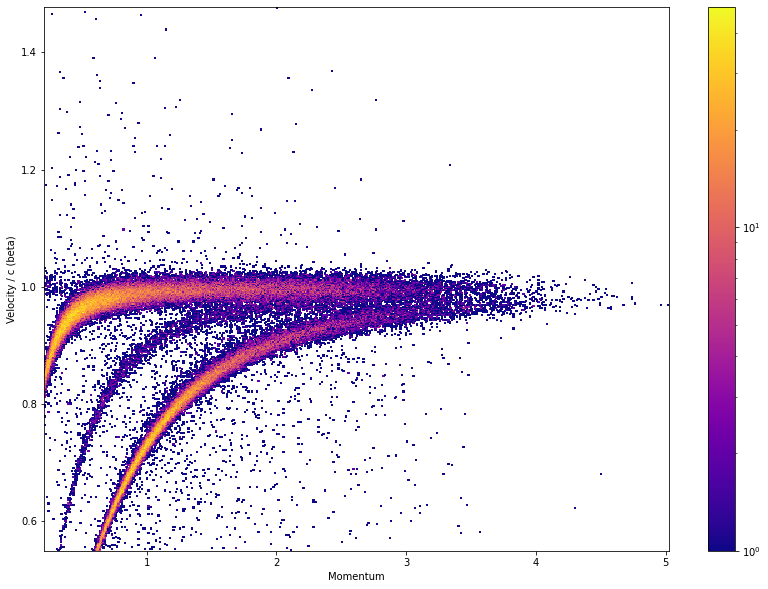

In [4]:
fig = plt.figure(figsize=(14,10))
plt.hist2d(datasetTrain.p,datasetTrain.beta,bins=500,cmap='plasma',norm=colors.LogNorm())
plt.xlabel("Momentum")
plt.ylabel("Velocity / c (beta)")
cb = plt.colorbar()
plt.show()

# Now let's plot the data as separate classes

This allows us to gain a bit more insight into what we're looking at.

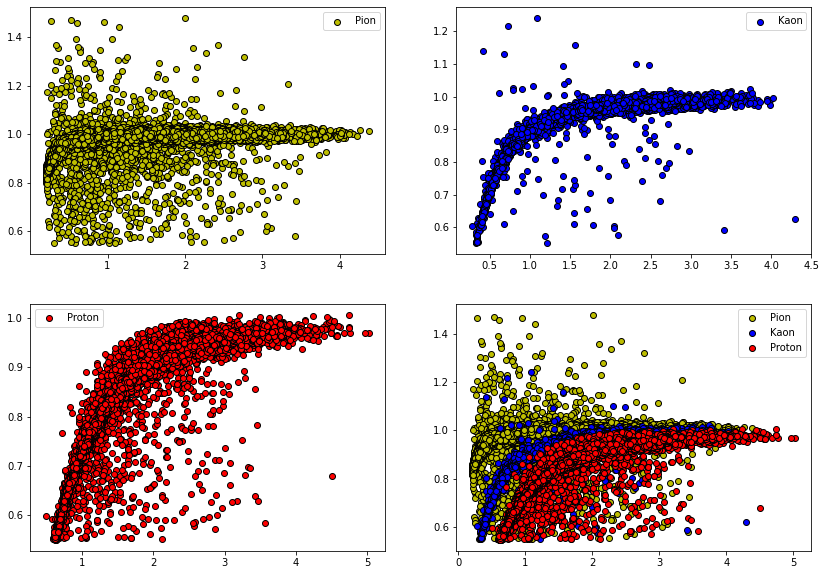

In [5]:
fig, ax = plt.subplots(2,2,figsize=(14,10))

ax[0,0].scatter(X_train[pionIdx][:,0],X_train[pionIdx][:,1],c='y',edgecolor='black',label="Pion")
ax[0,0].legend()
ax[0,1].scatter(X_train[kaonIdx][:,0],X_train[kaonIdx][:,1],c='b',edgecolor='black',label="Kaon")
ax[0,1].legend()
ax[1,0].scatter(X_train[protIdx][:,0],X_train[protIdx][:,1],c='r',edgecolor='black',label="Proton")
ax[1,0].legend()
ax[1,1].scatter(X_train[pionIdx][:,0],X_train[pionIdx][:,1],c='y',edgecolor='black',label="Pion")
ax[1,1].scatter(X_train[kaonIdx][:,0],X_train[kaonIdx][:,1],c='b',edgecolor='black',label="Kaon")
ax[1,1].scatter(X_train[protIdx][:,0],X_train[protIdx][:,1],c='r',edgecolor='black',label="Proton")
ax[1,1].legend()
plt.show()